## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_annotations ="s3://aegovan-data/processed_dataset/input_data_pubtator_annotated_human.txt"
s3_results_prefix = "s3://aegovan-data/processed_dataset/"
human_idmapping_dat = "./data/HUMAN_9606_idmapping.dat"
idmapping_dat="./tmpmap.dat"

In [2]:
!cp $human_idmapping_dat $idmapping_dat
!wc -l $idmapping_dat

 6069679 ./tmpmap.dat


In [3]:
import logging, sys

# Set up logging
logging.basicConfig(level=logging.getLevelName("INFO"), handlers=[logging.StreamHandler(sys.stdout)],
                        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [5]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [6]:
download_single_file(s3_data, data_file)

2021-05-22 13:50:36,478 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
download_single_file(s3_annotations, annotations_file)

In [8]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [9]:
data.pubmedId.nunique()

850

In [10]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times']
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [11]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [12]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
2,1585519,phosphorylation,"[{'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been 

In [13]:
data.shape

(3381, 7)

In [14]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

## Duplicate interactions

In [15]:
def flat_participants_list(list_of_uniprot_dict):
    return frozenset([item["uniprotid"]  for item in list_of_uniprot_dict])
         
data["flatparticpants"]= data["participants"].apply(flat_participants_list)

In [16]:
data.groupby(["pubmedId", "flatparticpants", "interactionType"])\
    .filter(lambda x: len(x) > 1)\
    .groupby(["pubmedId", "flatparticpants", "interactionType"])\
    .size()\
    .sort_values(ascending=False)


pubmedId  flatparticpants         interactionType  
23560844  (P28482, P35813)        dephosphorylation    17
22514276  (Q14524, Q13557)        phosphorylation      12
19407811  (Q92831, O60566)        acetylation          10
20729810  (P43250, P52205)        phosphorylation       9
27373337  (Q9HCE5, Q86U44, None)  methylation           9
                                                       ..
21887822  (P08107, P53350)        phosphorylation       2
          (P23588, P53350)        phosphorylation       2
21806020  (P18031, P05556)        dephosphorylation     2
21782458  (Q9NRG4, P04637)        methylation           2
10366608  (P17612, P48058)        phosphorylation       2
Length: 353, dtype: int64

In [17]:
data.query("pubmedId=='23560844'")[["pubmedId",  "flatparticpants", "interactionType","interactionId"]]\
    .sort_values(by="interactionId")

,pubmedId,flatparticpants,interactionType,interactionId
2348,23560844,"(P28482, P35813)",dephosphorylation,1403258
2349,23560844,"(P28482, P35813)",dephosphorylation,1403266
2350,23560844,"(Q16539, P35813)",dephosphorylation,1403273
2351,23560844,"(Q16539, P35813)",dephosphorylation,1403280
2352,23560844,"(P28482, P35813)",dephosphorylation,1403286
2353,23560844,"(P28482, P35813)",dephosphorylation,1403295
2354,23560844,"(P28482, P35813)",dephosphorylation,1403303
2355,23560844,"(P28482, P35813)",dephosphorylation,1403312
2356,23560844,"(P28482, P35813)",dephosphorylation,1403321
2357,23560844,"(P28482, P35813)",dephosphorylation,1403330


### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


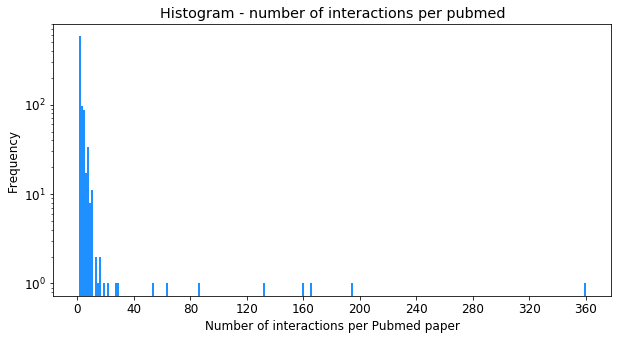

In [18]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.eps', bbox_inches='tight')
plt.savefig('PaperVsInteractions.png', bbox_inches='tight')
plt.show()

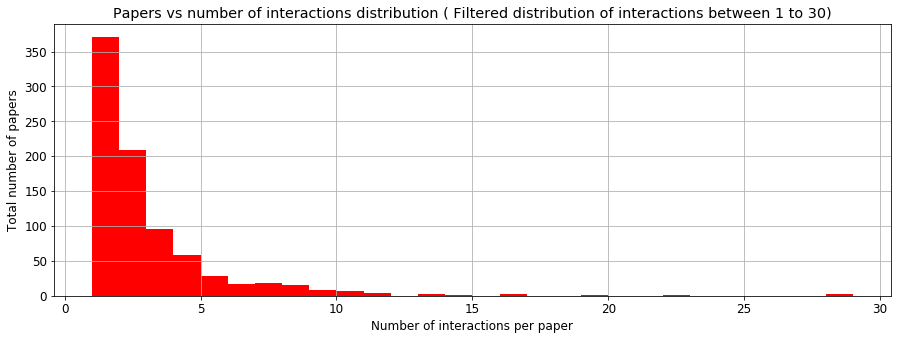

In [19]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

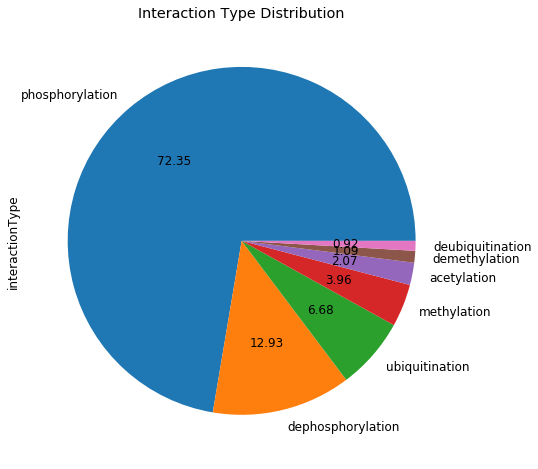

In [20]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [21]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

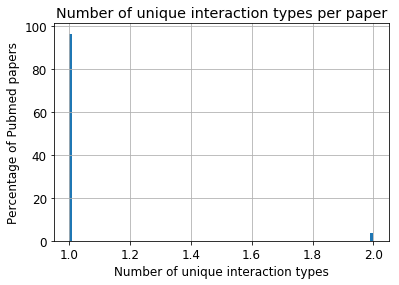

In [22]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

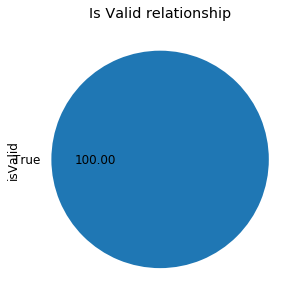

In [23]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

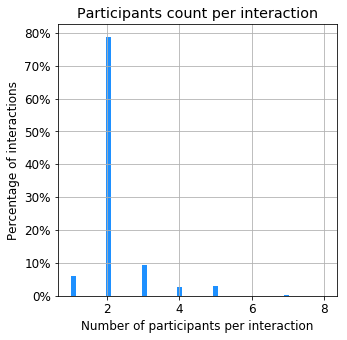

In [24]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Explore if the abstract contains the trigger word

In [25]:
!pip install nltk==3.4.5

You should consider upgrading via the '/Users/aeg/venv/PPI-typed-relation-extractor/bin/python -m pip install --upgrade pip' command.


In [26]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = PorterStemmer()
print(pd.DataFrame(data.interactionType.unique()).apply(lambda r: stemmer.stem(r.iloc[0].lower()), axis=1))

data["hasTriggerWord"] = data.apply(lambda r: stemmer.stem(r["interactionType"].lower()) in r["pubmedabstract"].lower() , 1)

0      phosphoryl
1    dephosphoryl
2          methyl
3          acetyl
4     deubiquitin
5       ubiquitin
6        demethyl
dtype: object


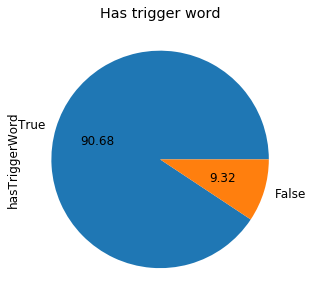

In [27]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [28]:
data.groupby([ 'interactionType','hasTriggerWord']).size().unstack().apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,7.1,92.9
demethylation,2.7,97.3
dephosphorylation,11.4,88.6
deubiquitination,22.6,77.4
methylation,0.7,99.3
phosphorylation,10.1,89.9
ubiquitination,1.8,98.2


### Explore how many of the entity alias are mentioned in the abstract

In [29]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 19.7 s, sys: 59.8 ms, total: 19.8 s
Wall time: 19.6 s


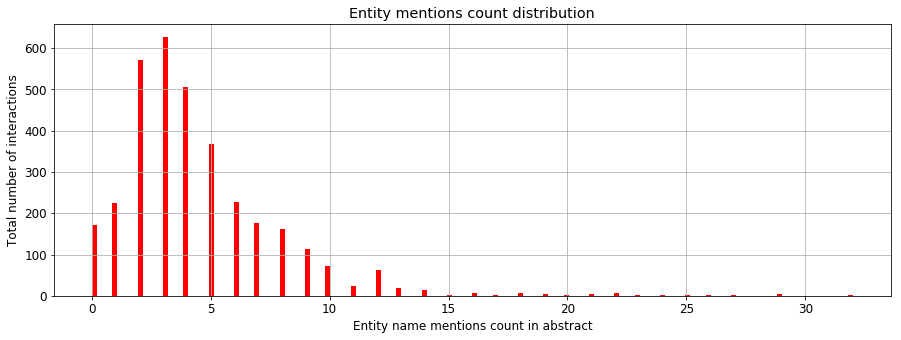

In [30]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

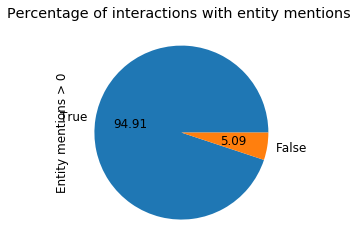

In [31]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [32]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
809,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'P08238', 'alias': [['hs90b_human'], ['Heat shock protein HSP 90-beta'], ['HSP90AB1'], ['HSP90B'], ['HSPC2'], ['HSPCB'], ['Heat shock 84 kDa']], 'alternative_uniprots': ['Q9NTK6', 'Q5T9W7', 'B2R5P0', 'Q9NQW0']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
774,"[{'uniprotid': 'P20042', 'alias': [['if2b_human'], ['Eukaryotic translation initiation factor 2 subunit 2'], ['Eukaryotic translation initiation factor 2 subunit beta'], ['EIF2S2'], ['EIF2B']], 'alternative_uniprots': ['Q9UJE4', 'Q9BVU0']}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
808,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'Q5JSH3-1', 'alias': [['q5jsh3-1'], ['WD repeat-containing protein 44'], ['WDR44'], ['Rabphilin-11']], 'alternative_uniprots': []}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."


In [33]:
data.head(n=2)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"(O43293-2, Q10728)",2,True,9
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"(O43293-1, Q10728)",2,True,9


## Data Transformation

### Drop duplicates by ["pubmedId", "flatparticpants", "interactionType"]

In [34]:
data.shape

(3381, 11)

In [35]:
process_map =[]
process_map.append({"name": "Initial", "count": len(data) })

In [36]:
filtered = data.drop_duplicates(subset=["pubmedId", "flatparticpants", "interactionType"], keep='last')
process_map.append({"name": "Drop duplicates (pubmedId, participant uniprots, interactionType)", 
             "count": len(filtered) })

filtered.shape

(2797, 11)

### Filter interactions with  participants != 2

In [37]:
filtered = filtered[~filtered.pubmedId.isin( filtered.query('participants_count > 2').pubmedId)]

process_map.append({"name": "Drop abstracts that have n-ary relationship n > 2",
                    "count": len(filtered) })

filtered.shape

(2217, 11)

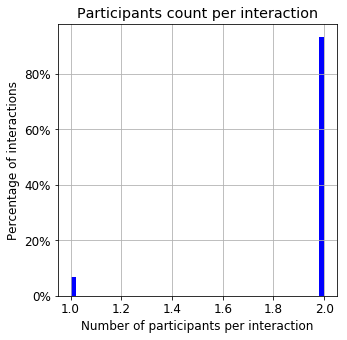

In [38]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

###  Flatten partcipants into participant 1 and particpiant 2

In [39]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [40]:
data_transformed.head(n=2)

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias
0,1585513,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[O43293-2, Q10728]",2,True,9,Q10728,O43293-2,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]","[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]"
1,1585516,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[O43293-1, Q10728]",2,True,9,O43293-1,Q10728,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]","[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]"


In [41]:
data_transformed.shape

(2217, 14)

### Remove records where the participantId is null

In [42]:
data_transformed.shape

(2217, 14)

In [43]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull() & data_transformed.participant2Id.notnull() ]
process_map.append({"name": "Drop interactions where participant Unitprot identifiers are null",
                    "count": len(data_filtered) })
data_filtered.shape

(2155, 14)

In [44]:
data_filtered.head(n=2)

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias
0,1585513,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[O43293-2, Q10728]",2,True,9,Q10728,O43293-2,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]","[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]"
1,1585516,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[O43293-1, Q10728]",2,True,9,O43293-1,Q10728,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]","[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]"


### Normalise abstract

In [45]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.ncbiGeneUniprotMapper import NcbiGeneUniprotMapper


    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.textGeneNormaliser import TextGeneNormaliser


    import os
    
 
    localdb = idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
        
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))
        
        
        # 
        normaliser = AbstractGeneNormaliser(annotations_json)
        normaliser.text_gene_normaliser = TextGeneNormaliser(geneIdConverter = mapper) 
        result = normaliser.transform(data)
        
       

        return result

In [46]:
%%time

data_filtered = normalise_absract(data_filtered.copy(deep=True), annotations_file)

2021-05-22 13:51:22,306 - datatransformer.abstractGeneNormaliser - INFO - Starting transformation..
2021-05-22 13:51:25,897 - datatransformer.abstractGeneNormaliser - INFO - Completed normalised abstract...
2021-05-22 13:51:25,898 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations ...
2021-05-22 13:51:25,930 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations_abstract...
2021-05-22 13:51:25,968 - datatransformer.abstractGeneNormaliser - INFO - Adding num_unique_gene_normalised_id...
2021-05-22 13:51:25,979 - datatransformer.abstractGeneNormaliser - INFO - Adding num_gene_normalised_id...
2021-05-22 13:51:25,989 - datatransformer.abstractGeneNormaliser - INFO - Gene Id links...
2021-05-22 13:51:26,073 - datatransformer.abstractGeneNormaliser - INFO - Completed normalised abstract...
2021-05-22 13:51:26,073 - datatransformer.abstractGeneNormaliser - INFO - Completed transformation
CPU times: user 3.75 s, sys: 44.2 ms, total: 3.8 s
Wall time: 3.8 s


In [47]:
data_filtered.shape

(2155, 23)

In [48]:
data_filtered.head(n=3)

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias,normalised_abstract,normalised_abstract_annotations,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,participant1Name,participant2Name
0,1585513,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[O43293-2, Q10728]",2,True,9,Q10728,O43293-2,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]","[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]","O43293 (O43293) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that O43293 also plays a role in regulating Q7Z406 phosphorylation. Here, we found novel O43293 isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to O14974(O14974) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to Q7Z406. These results indicate that a leucine zipper is not critical for the binding of O43293 to O14974 and Q7Z406. Consistently, hZIPK-S localized with stress-fibers where they co-localized with Q7Z406. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to O14974, while the Q7Z406 binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of Q7Z406 phosphorylation.","[{'charOffset': 0, 'len': 6, 'text': 'O43293'}, {'charOffset': 8, 'len': 6, 'text': 'O43293'}, {'charOffset': 166, 'len': 6, 'text': 'O43293'}, {'charOffset': 205, 'len': 6, 'text': 'Q7Z406'}, {'charOffset': 250, 'len': 6, 'text': 'O43293'}, {'charOffset': 377, 'len': 6, 'text': 'O14974'}, {'charOffset': 384, 'len': 6, 'text': 'O14974'}, {'charOffset': 493, 'len': 6, 'text': 'Q7Z406'}, {'charOffset': 581, 'len': 6, 'text': 'O43293'}, {'charOffset': 591, 'len': 6, 'text': 'O14974'}, {'charOffset': 602, 'len': 6, 'text': 'Q7Z406'}, {'charOffset': 690, 'len': 6, 'text': 'Q7Z406'}, {'charOffset': 820, 'len': 6, 'text': 'O14974'}, {'charOffset': 838, 'len': 6, 'text': 'Q7Z406'}, {'charOffset': 1012, 'len': 6, 'text': 'Q7Z406'}]","[{'start': '0', 'end': '33', 'name': 'Zipper-interacting protein kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '35', 'end': '45', 'name': 'ZIP kinase', 

In [49]:
data_filtered.query("interactionType == 'acetylation'").shape

(41, 23)

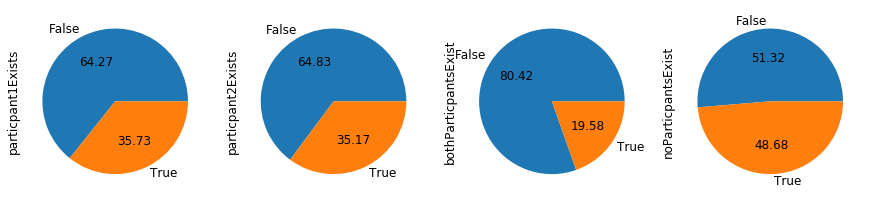

In [50]:

fig, ax =  plt.subplots( 1,4, figsize=(15,5))

tmp = pd.DataFrame()

data_filtered["particpant1Exists"] = data_filtered.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant1Exists"].value_counts().plot.pie(ax=ax[0], autopct='%.2f')

data_filtered["particpant2Exists"] = data_filtered.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant2Exists"].value_counts().plot.pie(ax=ax[1], autopct='%.2f')


data_filtered["bothParticpantsExist"] = data_filtered.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)
data_filtered["bothParticpantsExist"].value_counts().plot.pie(ax=ax[2], autopct='%.2f')

data_filtered["noParticpantsExist"] = data_filtered.apply(lambda r: not (r["particpant2Exists"] or r["particpant1Exists"])   , 1)
data_filtered["noParticpantsExist"].value_counts().plot.pie(ax=ax[3], autopct='%.2f')


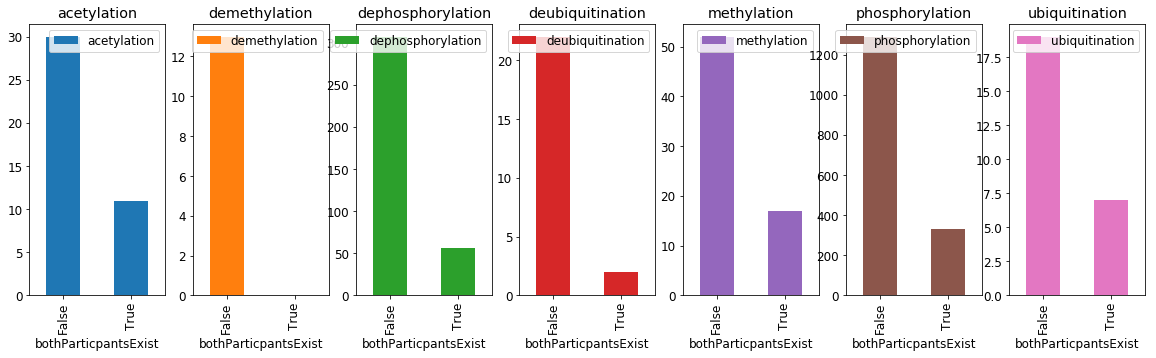

In [51]:
fig, ax = plt.subplots(1,7, figsize=(20,5))

data_filtered.groupby([ "bothParticpantsExist", 'interactionType']).size().unstack().plot.bar(subplots=True, ax=ax)
plt.show()

In [52]:
data_filtered.query("particpant2Exists == False").sample(4)

interactionId  interactionType  pubmedId pubmedTitle  \
516        1272148  phosphorylation  22094256        None   
550        1272799  phosphorylation  22113938        None   
488        1272008  phosphorylation  22094256        None   
1059        705499  phosphorylation  10733566        None   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            pubmedabstract  \
516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### Remove abstracts where both participants do not exists

In [53]:
data_filtered =  data_filtered.query('bothParticpantsExist == True')
process_map.append({"name": "Drop interactions where the participant UniprotID does not exist in abstract",
                    "count": len(data_filtered) })
data_filtered.shape

(422, 27)

In [54]:
data_filtered.query("interactionType == 'acetylation'").shape

(11, 27)

In [55]:
process_map

[{'name': 'Initial', 'count': 3381},
 {'name': 'Drop duplicates (pubmedId, participant uniprots, interactionType)',
  'count': 2797},
 {'name': 'Drop abstracts that have n-ary relationship n > 2', 'count': 2217},
 {'name': 'Drop interactions where participant Unitprot identifiers are null',
  'count': 2155},
 {'name': 'Drop interactions where the participant UniprotID does not exist in abstract',
  'count': 422}]

### Drop PPIs without trigger word

In [56]:
data_filtered =  data_filtered.query('hasTriggerWord == True')
process_map.append({"name": "Drop interactions where the abstract does not contain the trigger word",
                    "count": len(data_filtered) })
data_filtered.shape

(376, 27)

### Remove self relations

In [57]:
data_filtered =  data_filtered.query('participant1Id != participant2Id')
process_map.append({"name": "Drop interactions where participant1 = participant2 (self relations)",
                    "count": len(data_filtered) })

data_filtered.shape

(279, 27)

In [58]:
process_map

[{'name': 'Initial', 'count': 3381},
 {'name': 'Drop duplicates (pubmedId, participant uniprots, interactionType)',
  'count': 2797},
 {'name': 'Drop abstracts that have n-ary relationship n > 2', 'count': 2217},
 {'name': 'Drop interactions where participant Unitprot identifiers are null',
  'count': 2155},
 {'name': 'Drop interactions where the participant UniprotID does not exist in abstract',
  'count': 422},
 {'name': 'Drop interactions where the abstract does not contain the trigger word',
  'count': 376},
 {'name': 'Drop interactions where participant1 = participant2 (self relations)',
  'count': 279}]

In [59]:
data_filtered.query("interactionType == 'acetylation'").shape

(7, 27)

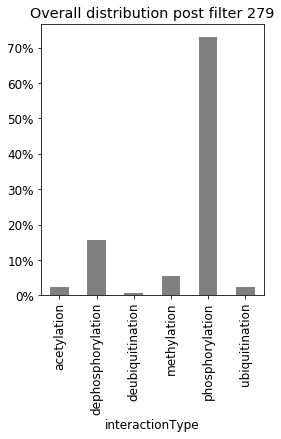

In [60]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))

c_ax= ax
c_ax.set_title('Overall distribution post filter {}'.format(data_filtered.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='gray')


plt.savefig("Interactiontype_postfilter.eps", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

In [61]:
data_filtered.groupby(['interactionType']).size()

interactionType
acetylation            7
dephosphorylation     44
deubiquitination       2
methylation           15
phosphorylation      204
ubiquitination         7
dtype: int64

#### Check how many contain the trigger word

In [62]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0)

hasTriggerWord,True
interactionType,
acetylation,7
dephosphorylation,44
deubiquitination,2
methylation,15
phosphorylation,204
ubiquitination,7


In [63]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0).apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,True
interactionType,
acetylation,100.0
dephosphorylation,100.0
deubiquitination,100.0
methylation,100.0
phosphorylation,100.0
ubiquitination,100.0


In [64]:
data_filtered.query('pubmedId == "17126281"')

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias,normalised_abstract,normalised_abstract_annotations,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,participant1Name,participant2Name,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist


In [65]:
data_filtered.query("interactionType == 'acetylation'")[["interactionType", "pubmedId", "pubmedTitle",
                                                         "participant1Id", "participant2Id" ]]

,interactionType,pubmedId,pubmedTitle,participant1Id,participant2Id
715,acetylation,20856196,None,Q09472,P27695
797,acetylation,26829474,Acetylation of Aurora B by TIP60 ensures accurate chromosomal segregation.,Q96GD4,Q92993
1228,acetylation,22771473,None,Q92831,P63241
1415,acetylation,19407811,None,O60566,Q92831
1557,acetylation,21157427,None,Q01130,Q92993
1573,acetylation,23441852,None,Q09472,P61201
1632,acetylation,11804596,None,O15350,Q09472


### Verify no duplicates

In [66]:
duplicates = data_filtered.groupby(["interactionType", "pubmedId", "participant1Id", "participant2Id"])\
    .filter(lambda x: len(x) > 1)\
    .groupby(["interactionType", "pubmedId", "participant1Id", "participant2Id"]).size()

assert len(duplicates)==0

In [67]:
process_map

[{'name': 'Initial', 'count': 3381},
 {'name': 'Drop duplicates (pubmedId, participant uniprots, interactionType)',
  'count': 2797},
 {'name': 'Drop abstracts that have n-ary relationship n > 2', 'count': 2217},
 {'name': 'Drop interactions where participant Unitprot identifiers are null',
  'count': 2155},
 {'name': 'Drop interactions where the participant UniprotID does not exist in abstract',
  'count': 422},
 {'name': 'Drop interactions where the abstract does not contain the trigger word',
  'count': 376},
 {'name': 'Drop interactions where participant1 = participant2 (self relations)',
  'count': 279}]

### Split Train/Test/validation

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [69]:
data_filtered.query("interactionType == 'demethylation'")['pubmedId'].unique()

array([], dtype=object)

In [70]:
data_filtered.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '14603323', '11894096', '11882901',
       '16601676', '11027293'], dtype=object)

In [71]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [72]:
train.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '14603323', '11882901', '16601676', '11027293'],
      dtype=object)

In [73]:
val.query("interactionType == 'ubiquitination'")


,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias,normalised_abstract,normalised_abstract_annotations,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,participant1Name,participant2Name,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1639,7982,ubiquitination,11894096,None,"Ligand-dependent downregulation of tyrosine kinase receptors is a critical step for modulating their activity. Upon ligand binding, hepatocyte growth factor (HGF) receptor (Met) is polyubiquitinated and degraded; however, the mechanisms underlying HGF receptor endocytosis are not yet known. Here we demonstrate that a complex involving endophilins, CIN85 and Cbl controls this process. Endophilins are regulatory components of clathrin-coated vesicle formation. Through their acyl-transferase activity they are thought to modify the membrane phospholipids and induce negative curvature and invagination of the plasma membrane during the early steps of endocytosis. Furthermore, by means of their Src-homology 3 domains, endophilins are able to bind CIN85, a recently identified protein that interacts with the Cbl proto-oncogene. Cbl, in turn, binds and ubiquitinates activated HGF receptor, and by recruiting the endophilin-CIN85 complex, it regulates receptor internalization. Inhibition of complex formation is sufficient to block HGF receptor internalization and to enhance HGF-induced signal transduction and biological responses. These data provide further evidence of a relationship between receptor-mediated signalling and endocytosis, and disclose a novel functional role for Cbl in HGF receptor signalling.",True,"[P08581, P22681]",2,True,8,P22681,P08581,"[[cbl_human], [E3 ubiquitin-protein ligase CBL], [RING-type E3 ubiquitin transferase CBL], [Signal transduction protein CBL], [Proto-oncogene c-Cbl], [Casitas B-lineage lymphoma proto-oncogene], [RING finger protein 55], [CBL], [CBL2], [RNF55]]","[[met_human], [Hepatocyte growth factor receptor], [MET], [Scatter factor receptor], [HGF/SF receptor], [Tyrosine-protein kinase Met], [Proto-oncogene c-Met]]","Ligand-dependent downregulation of tyrosine kinase receptors is a critical step for modulating their activity. Upon ligand binding, P08581 (Met) is polyubiquitinated and degraded; however, the mechanisms underlying P08581 endocytosis are not yet known. Here we demonstrate that a complex involving endophilins, Q96B97 and P22681 controls this process. Endophilins are regulatory components of clathrin-coated vesicle formation. Through their acyl-transferase activity they are thought to modify the membrane phospholipids and induce negative curvature and invagination of the plasma membrane during the early steps of endocytosis. Furthermore, by means of their Src-homology 3 domains, endophilins are able to bind Q96B97, a recently identified protein that interacts with the P22681 proto-oncogene. P22681, in turn, binds and ubiquitinates activated P08581, and by recruiting the endophilin-Q96B97 complex, it regulates receptor internalization. Inhibition of complex formation is sufficient to block P08581 internalization and to enhance P14210-induced signal transduction and biological responses. These data provide further evidence of a relationship between receptor-mediated signalling and endocytosis, and disclose a novel functional role for P22681 in P08581 signalling.","[{'charOffset': 132, 'len': 6, 'text': 'P08581'}, {'charOffset': 215, 'len': 6, 'text': 'P08581'}, {'charOffset': 311, 'len': 6, 'text': 'Q96B97'}, {'charOffset': 322, 'len': 6, 'text': 'P22681'}, {'charOffset': 715, 'len': 6, 'text': 'Q96B97'}, {'charOffset': 777, 'len': 6, 'text': 'P22681'}, {'charOffset': 800, 'len': 6, 'text': 'P22681'}, {'charOffset': 851, 'len': 6, 'text': 'P08581'}, {'charOffset': 892, 'len': 6, 't

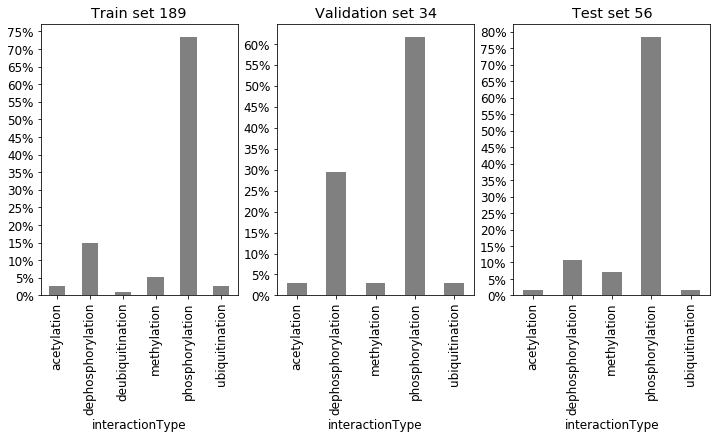

In [74]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set {}'.format(train.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set {}'.format(val.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='gray')



c_ax = ax[2] 
c_ax.set_title('Test set {}'.format(test.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='gray')




plt.savefig("split_dataset_postfilter.eps", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

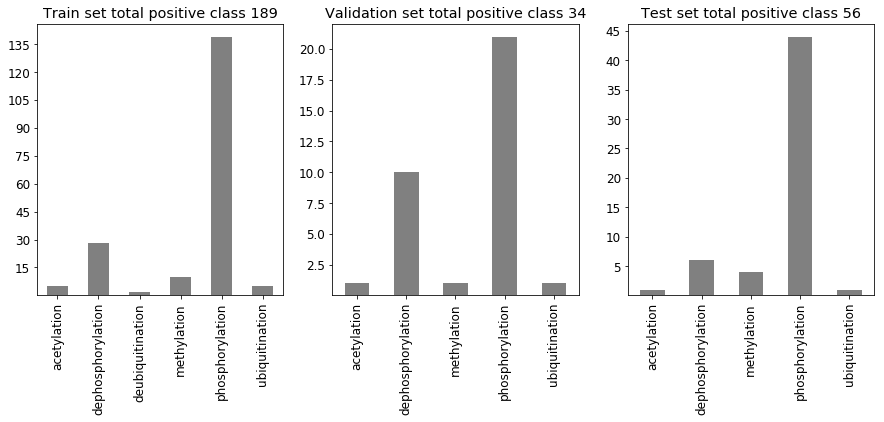

In [75]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='gray')


plt.savefig('TrainTestValidationInteractionDistribution.eps', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.png', bbox_inches='tight')


plt.show()

### Sample network

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


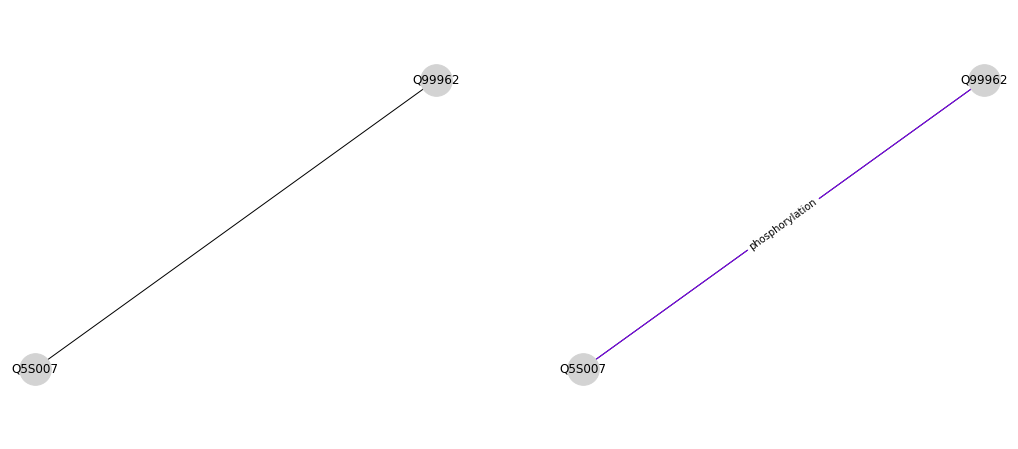

In [76]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(a=78, version=2)

fig,ax=plt.subplots(1,2, figsize=(18,8))

G=nx.Graph()
# Add nodes and edges
G.add_edges_from(train.query(" participant2Id =='Q5S007' and participant1Id != participant2Id")
                 .apply(lambda x: ( x["participant1Id"],x["participant2Id"], {"type": x['interactionType']}), axis=1))


pos = nx.spring_layout(G,  seed=80)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[0])


edge_label = nx.get_edge_attributes(G,'type')

colors = {i:random.randint(0, 50) for i in train['interactionType'].unique()}
edge_colors = [ colors[l]  for _,l in edge_label.items()]

cmap=plt.cm.get_cmap("rainbow")
vmin = min(edge_colors)
vmax = max(edge_colors)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[1])
nx.draw_networkx_edges(G, pos,  width=1.0, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_edge_labels(G, pos=pos,alpha=1, edge_labels = nx.get_edge_attributes(G,'type'), ax=ax[1])

plt.savefig('network.pdf', bbox_inches="tight")



plt.show()

### Generate negative samples

In [77]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [78]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [79]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [80]:
def generate_negative_missing_participant(data):


    import os
    
    data['isValid'] = data['isValid'].mask( (data['bothParticpantsExist'] == False) & (data['isValid'] == True) , False)


    return data

In [81]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[1]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[2]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



   

#### Step1: Add negative entity pairs

In [82]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



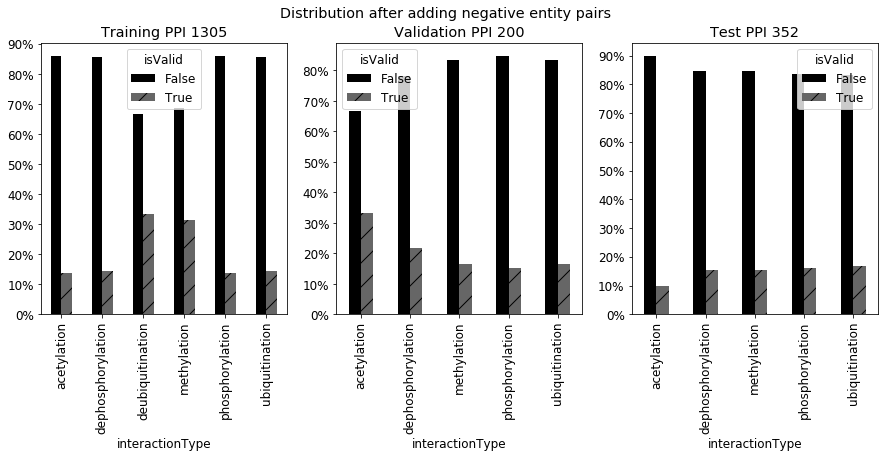

In [83]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

plt.style.use('grayscale')

plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.eps",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

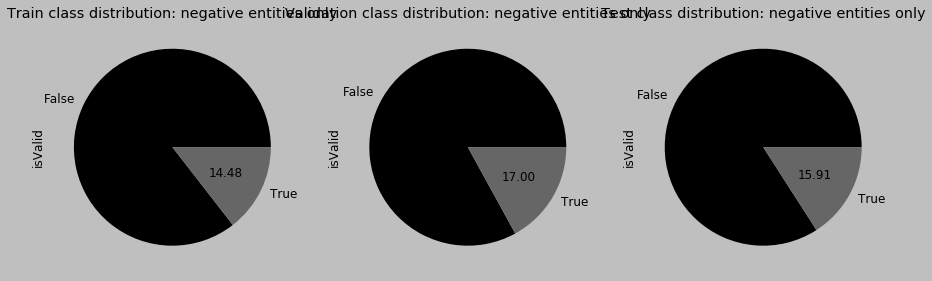

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution: negative entities only')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution: negative entities only')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution: negative entities only')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("PositiveVsNegative_EntityOnly.png")

In [85]:
train_file ="train_unique_negative_entity_only.json"
train.to_json(train_file)

test_file ="test_unique_negative_entity_only.json"
test.to_json(test_file)

val_file = "val_unique_negative_entity_only.json"
val.to_json(val_file)



In [86]:


from helpers.s3_util import S3Util

S3Util().uploadfile(train_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(val_file, "{}/".format( s3_results_prefix.rstrip("/")) )

2021-05-22 13:51:54,712 - helpers.s3_util - INFO - Uploading file train_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/train_unique_negative_entity_only.json
2021-05-22 13:52:38,043 - helpers.s3_util - INFO - Uploading file test_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/test_unique_negative_entity_only.json
2021-05-22 13:52:52,092 - helpers.s3_util - INFO - Uploading file val_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/val_unique_negative_entity_only.json


In [87]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,31,5
dephosphorylation,167,28
deubiquitination,4,2
methylation,22,10
phosphorylation,862,139
ubiquitination,30,5


In [88]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,2,1
dephosphorylation,36,10
methylation,5,1
phosphorylation,118,21
ubiquitination,5,1


In [89]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,9,1
dephosphorylation,33,6
methylation,22,4
phosphorylation,227,44
ubiquitination,5,1


In [90]:
pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())

isValid,False,True
interactionType,,
acetylation,31,5
dephosphorylation,167,28
deubiquitination,4,2
methylation,22,10
phosphorylation,862,139
ubiquitination,30,5


In [91]:
t = pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())
t.columns =["False", "True"]

v = pd.DataFrame(val.groupby(['interactionType', 'isValid']).size().unstack())
v.columns = ["False", "True"]

b = pd.DataFrame(test.groupby(['interactionType', 'isValid']).size().unstack())
b.columns = ["False", "True"]

m = t.merge(v, left_index = True, right_index=True, how="left", suffixes=('_train', '_val'))\
       .merge(b, left_index = True, right_index=True, how="left")\

m=m.fillna(0)

m.loc["Total"] = m.apply(lambda x: sum(x))

m["TotalFalse"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'false' in k.lower()]), axis=1)
m["TotalTrue"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'true' in k.lower()]), axis=1)



print(m.astype('int32').to_latex())
    

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  False\_train &  True\_train &  False\_val &  True\_val &  False &  True &  TotalFalse &  TotalTrue \\
interactionType   &              &             &            &           &        &       &             &            \\
\midrule
acetylation       &           31 &           5 &          2 &         1 &      9 &     1 &          42 &          7 \\
dephosphorylation &          167 &          28 &         36 &        10 &     33 &     6 &         236 &         44 \\
deubiquitination  &            4 &           2 &          0 &         0 &      0 &     0 &           4 &          2 \\
methylation       &           22 &          10 &          5 &         1 &     22 &     4 &          49 &         15 \\
phosphorylation   &          862 &         139 &        118 &        21 &    227 &    44 &        1207 &        204 \\
ubiquitination    &           30 &           5 &          5 &         1 &      5 &     1 &          40 &          7 \\
Total         

In [92]:
feature_cols = ["pubmedId","pubmedabstract","annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id", "normalised_abstract","normalised_abstract_annotations", "participant1Id", "participant2Id", "gene_to_uniprot_map", "participant1Name", "participant2Name"]

derive_class_func = lambda r: r["interactionType"] if r["isValid"] else "other"


In [93]:

train_multiclass = train[ feature_cols]
train_multiclass["class"] = train.apply( derive_class_func, axis=1)

test_multiclass =  test[ feature_cols]
test_multiclass["class"] = test.apply( derive_class_func, axis=1)

val_multiclass =  val[ feature_cols]
val_multiclass["class"] = val.apply( derive_class_func, axis=1)

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [94]:
train_multiclass["class"].value_counts()

other                1116
phosphorylation       139
dephosphorylation      28
methylation            10
acetylation             5
ubiquitination          5
deubiquitination        2
Name: class, dtype: int64

In [95]:
test_multiclass["class"].value_counts()

other                296
phosphorylation       44
dephosphorylation      6
methylation            4
acetylation            1
ubiquitination         1
Name: class, dtype: int64

In [96]:
val_multiclass["class"].value_counts()

other                166
phosphorylation       21
dephosphorylation     10
acetylation            1
ubiquitination         1
methylation            1
Name: class, dtype: int64

In [97]:
train_multi_file="train_multiclass.json"
train_multiclass.to_json(train_multi_file)

test_multi_file="test_multiclass.json"
test_multiclass.to_json(test_multi_file)

val_multi_file="val_multiclass.json"
val_multiclass.to_json(val_multi_file)

In [98]:
val_multiclass.head(n=1)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,participant1Name,participant2Name,class
0,17141222,"Regulation of growth factor dependent cell survival is crucial for development and disease progression. Here, we report a novel function of Src kinases as a negative regulator of platelet-derived growth factor (PDGF) dependent cell survival. We characterized a series of PDGF alpha receptor (PDGFRA) mutants, which lack the binding sites for Src, phosphatidylinositol 3'-kinase (PI3K), SHP-2 or phospholipase C-gamma. We found that PDGFRA-dependent cell survival was mainly mediated through activation of PI3K, and was negatively regulated by Src. Characterization of the downstream signaling events revealed that PI3K activates the protein kinase Akt, which in turn phosphorylates and thus inactivates proapoptotic Forkhead transcription factors. Src phosphorylates the ubiquitin-ligase c-Cbl, which is required for degradation of the activated receptor. Consequently, overexpression of c-Cbl prevented PDGFRA-mediated cell survival, whereas it did not affect this response, when Src was unable to associate with the receptor. This novel function of Src in antiapoptotic signaling introduces Src kinases as an interesting therapeutic target in apoptosis related diseases.","[{'start': '140', 'end': '143', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '292', 'end': '298', 'name': 'PDGFRA', 'type': 'Gene', 'normalised_id': '5156'}, {'start': '342', 'end': '345', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '347', 'end': '377', 'name': 'phosphatidylinositol 3'-kinase', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '379', 'end': '383', 'name': 'PI3K', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '386', 'end': '391', 'name': 'SHP-2', 'type': 'Gene', 'normalised_id': '5781'}, {'start': '432', 'end': '438', 'name': 'PDGFRA', 'type': 'Gene', 'normalised_id': '5156'}, {'start': '505', 'end': '509', 'name': 'PI3K', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '543', 'end': '546', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '614', 'end': '618', 'name': 'PI3K', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '748', 'end': '751', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '788', 'end': '793', 'name': 'c-Cbl', 'type': 'Gene', 'normalised_id': '867'}, {'start': '888', 'end': '893', 'name': 'c-Cbl', 'type': 'Gene', 'normalised_id': '867'}, {'start': '904', 'end': '910', 'name': 'PDGFRA', 'type': 'Gene', 'normalised_id': '5156'}, {'start': '981', 'end': '984', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '1051', 'end': '1054', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '1093', 'end': '1096', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}]",5,17,"Regulation of growth factor dependent cell survival is crucial for development and disease progression. Here, we report a novel function of P12931 kinases as a negative regulator of platelet-derived growth factor (PDGF) dependent cell survival. We characterized a series of PDGF alpha receptor (P16234) mutants, which lack the binding sites for P12931, P48736 (P48736), Q06124 or phospholipase C-gamma. We found that P16234-dependent cell survival was mainly mediated through activation of P48736, and was negatively regulated by P12931. Characterization of the downstream signaling events revealed that P48736 activates the protein kinase Akt, which in turn phosphorylates and thus inactivates proapoptotic Forkhead transcription factors. P12931 phosphorylates the ubiquitin-ligase P22681, which is required for degradation of the activated receptor. Consequently, overexpression of P22681 prevented P16234-mediated cell survival, whereas it did not affect this response, when P12931 was unable to associate with the receptor. Th

In [99]:
val_multiclass.query("`class` == 'other'" ).sample(n=5)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,participant1Name,participant2Name,class
165,15733869,"To maintain homeostasis, cells often respond to stressful extra-cellular stimuli by new gene expression. Serum/glucocorticoid-induced kinase (SGK) is an immediate early gene whose expression is induced by a variety of extra-cellular stimuli. Here, we examine the possibility that SGK can directly phosphorylate the transcription factor cyclic AMP response element binding protein (CREB). In a cell-free context, SGK physically associates with CREB and SGK phosphorylates it on serine 133. Phospho-serine 133 is essential for stimulating the transcriptional activity of CREB. Further, we show that in a variety of cellular contexts, SGK phosphorylates CREB. Activation of receptor tyrosine kinase pathways or the phosphoinositide-dependent kinase 1 (PDK1) lead to SGK-dependent CREB phosphorylation. Hormonal stimulation of epithelial cells leads to the induction of endogenous SGK and CREB phosphorylation. A dominant-negative form of SGK blocks dexamethasone-induced CREB phosphorylation. Our studies indicate that stimulation of SGK can lead to CREB phosphorylation, suggesting that CREB-dependent gene transcription is an important link between stressful extra-cellular signals and cellular responses.","[{'start': '105', 'end': '140', 'name': 'Serum/glucocorticoid-induced kinase', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '142', 'end': '145', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '280', 'end': '283', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '336', 'end': '379', 'name': 'cyclic AMP response element binding protein', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '381', 'end': '385', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '412', 'end': '415', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '443', 'end': '447', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '452', 'end': '455', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '569', 'end': '573', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '632', 'end': '635', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '651', 'end': '655', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '712', 'end': '747', 'name': 'phosphoinositide-dependent kinase 1', 'type': 'Gene', 'normalised_id': '5163'}, {'start': '749', 'end': '753', 'name': 'PDK1', 'type': 'Gene', 'normalised_id': '5163'}, {'start': '763', 'end': '766', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '777', 'end': '781', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '877', 'end': '880', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '885', 'end': '889', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '935', 'end': '938', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '968', 'end': '972', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '1031', 'end': '1034', 'name': 'SGK', 'type': 'Gene', 'normalised_id': '6446'}, {'start': '1047', 'end': '1051', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}, {'start': '1085', 'end': '1089', 'name': 'CREB', 'type': 'Gene', 'normalised_id': '1385'}]",3,22,"To maintain homeostasis, cells often respond to stressful extra-cellular stimuli by new gene expression. O00141 (O00141) is an immediate early gene whose expression is induced by a variety of extra-cellular stimuli. Here, we examine the possibility that O00141 can directly phosphorylate the transcription factor P16220 (P16220). In a cell-free context, O00141 physically associates with P16220 and O00141 phosphorylates it on serine 133. Phospho-serine 133 is essential for stimulat

In [104]:
val_multiclass.query("`class` != 'other' " ).sample(n=5)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,participant1Name,participant2Name,class
2,18201571,"MgcRacGAP, a Rho GAP essential to cytokinesis, works both as a Rho GTPase regulator and as a scaffolding protein. MgcRacGAP interacts with MKLP1 to form the centralspindlin complex and associates with the RhoGEF Ect2. The GAP activity of MgcRacGAP is regulated by Aurora B phosphorylation. We have isolated B56epsilon, a PP2A regulatory subunit, as a new MgcRacGAP partner. We report here that (i) MgcRacGAP is phosphorylated by Aurora B and Cdk1, (ii) PP2A dephosphorylates Aurora B and Cdk1 phosphorylated sites and (iii) inhibition of PP2A abrogates MgcRacGAP/Ect2 interaction. Therefore, PP2A may regulate cytokinesis by dephosphorylating MgcRacGAP and its interacting partners.","[{'start': '0', 'end': '9', 'name': 'MgcRacGAP', 'type': 'Gene', 'normalised_id': '29127'}, {'start': '114', 'end': '123', 'name': 'MgcRacGAP', 'type': 'Gene', 'normalised_id': '29127'}, {'start': '139', 'end': '144', 'name': 'MKLP1', 'type': 'Gene', 'normalised_id': '9493'}, {'start': '212', 'end': '216', 'name': 'Ect2', 'type': 'Gene', 'normalised_id': '1894'}, {'start': '238', 'end': '247', 'name': 'MgcRacGAP', 'type': 'Gene', 'normalised_id': '29127'}, {'start': '264', 'end': '272', 'name': 'Aurora B', 'type': 'Gene', 'normalised_id': '9212'}, {'start': '321', 'end': '325', 'name': 'PP2A', 'type': 'Gene', 'normalised_id': '5524'}, {'start': '355', 'end': '364', 'name': 'MgcRacGAP', 'type': 'Gene', 'normalised_id': '29127'}, {'start': '398', 'end': '407', 'name': 'MgcRacGAP', 'type': 'Gene', 'normalised_id': '29127'}, {'start': '429', 'end': '437', 'name': 'Aurora B', 'type': 'Gene', 'normalised_id': '9212'}, {'start': '442', 'end': '446', 'name': 'Cdk1', 'type': 'Gene', 'normalised_id': '983'}, {'start': '453', 'end': '457', 'name': 'PP2A', 'type': 'Gene', 'normalised_id': '5524'}, {'start': '475', 'end': '483', 'name': 'Aurora B', 'type': 'Gene', 'normalised_id': '9212'}, {'start': '488', 'end': '492', 'name': 'Cdk1', 'type': 'Gene', 'normalised_id': '983'}, {'start': '538', 'end': '542', 'name': 'PP2A', 'type': 'Gene', 'normalised_id': '5524'}, {'start': '553', 'end': '562', 'name': 'MgcRacGAP', 'type': 'Gene', 'normalised_id': '29127'}, {'start': '563', 'end': '567', 'name': 'Ect2', 'type': 'Gene', 'normalised_id': '1894'}, {'start': '592', 'end': '596', 'name': 'PP2A', 'type': 'Gene', 'normalised_id': '5524'}, {'start': '643', 'end': '652', 'name': 'MgcRacGAP', 'type': 'Gene', 'normalised_id': '29127'}]",6,19,"Q9H0H5, a Rho GAP essential to cytokinesis, works both as a Rho GTPase regulator and as a scaffolding protein. Q9H0H5 interacts with Q02241 to form the centralspindlin complex and associates with the RhoGEF Q9H8V3. The GAP activity of Q9H0H5 is regulated by Q96GD4 phosphorylation. We have isolated B56epsilon, a Q15257 regulatory subunit, as a new Q9H0H5 partner. We report here that (i) Q9H0H5 is phosphorylated by Q96GD4 and P06493, (ii) Q15257 dephosphorylates Q96GD4 and P06493 phosphorylated sites and (iii) inhibition of Q15257 abrogates Q9H0H5/Q9H8V3 interaction. Therefore, Q15257 may regulate cytokinesis by dephosphorylating Q9H0H5 and its interacting partners.","[{'charOffset': 0, 'len': 6, 'text': 'Q9H0H5'}, {'charOffset': 111, 'len': 6, 'text': 'Q9H0H5'}, {'charOffset': 133, 'len': 6, 'text': 'Q02241'}, {'charOffset': 207, 'len': 6, 'text': 'Q9H8V3'}, {'charOffset': 235, 'len': 6, 'text': 'Q9H0H5'}, {'charOffset': 258, 'len': 6, 'text': 'Q96GD4'}, {'charOffset': 313, 'len': 6, 'text': 'Q15257'}, {'charOffset': 349, 'len': 6, 'text': 'Q9H0H5'}, {'charOffset': 389, 'len': 6, 'text': 'Q9H0H5'}, {'charOffset': 417, 'len': 6, 'text': 'Q96GD4'}, {'charOffset': 428, 'len': 6, 'text': 'P06493'}, {'charOffset': 441, 'len': 6, 'text': 'Q15257'}, {'charOffset': 465, 'len': 6, 'text': 'Q96GD4'}, {'charOffset

In [100]:
from helpers.s3_util import S3Util

S3Util().uploadfile(val_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(train_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )

2021-05-22 13:53:01,418 - helpers.s3_util - INFO - Uploading file val_multiclass.json s3://aegovan-data/processed_dataset/val_multiclass.json
2021-05-22 13:53:09,072 - helpers.s3_util - INFO - Uploading file test_multiclass.json s3://aegovan-data/processed_dataset/test_multiclass.json
2021-05-22 13:53:20,119 - helpers.s3_util - INFO - Uploading file train_multiclass.json s3://aegovan-data/processed_dataset/train_multiclass.json


In [101]:
train_multiclass.sample(n=50).to_json("sample_train_multiclass.json")